# Training SVC

## Distribution of Data

Need to make sure that the training data is normalized and has almost equal number of Car and Non-Car samples

Total Cars: 8792
Total Non-Cars: 8968
Total Data: 17760
Total Training: 14208
Total Test: 3552


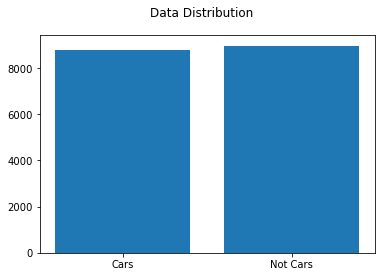

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

cars = glob.glob('./vehicles/**/*.png', recursive=True)
notcars = glob.glob('./non-vehicles/**/*.png', recursive=True)

#cars = glob.glob('./vehicles_smallset/**/*.jpeg', recursive=True)
#notcars = glob.glob('./non-vehicles_smallset/**/*.jpeg', recursive=True)

count = len(cars) + len(notcars)

print('Total Cars:', len(cars))
print('Total Non-Cars:', len(notcars))
print('Total Data:', count)
print('Total Training:', int(count * 0.8))
print('Total Test:', int(count * 0.2))

data = [len(cars), len(notcars)]
index = np.arange(2)
plt.bar(index, data)
plt.xticks(index, ('Cars', 'Not Cars'))
plt.suptitle('Data Distribution')
plt.show()

## Common Functions

## Color Space Choice

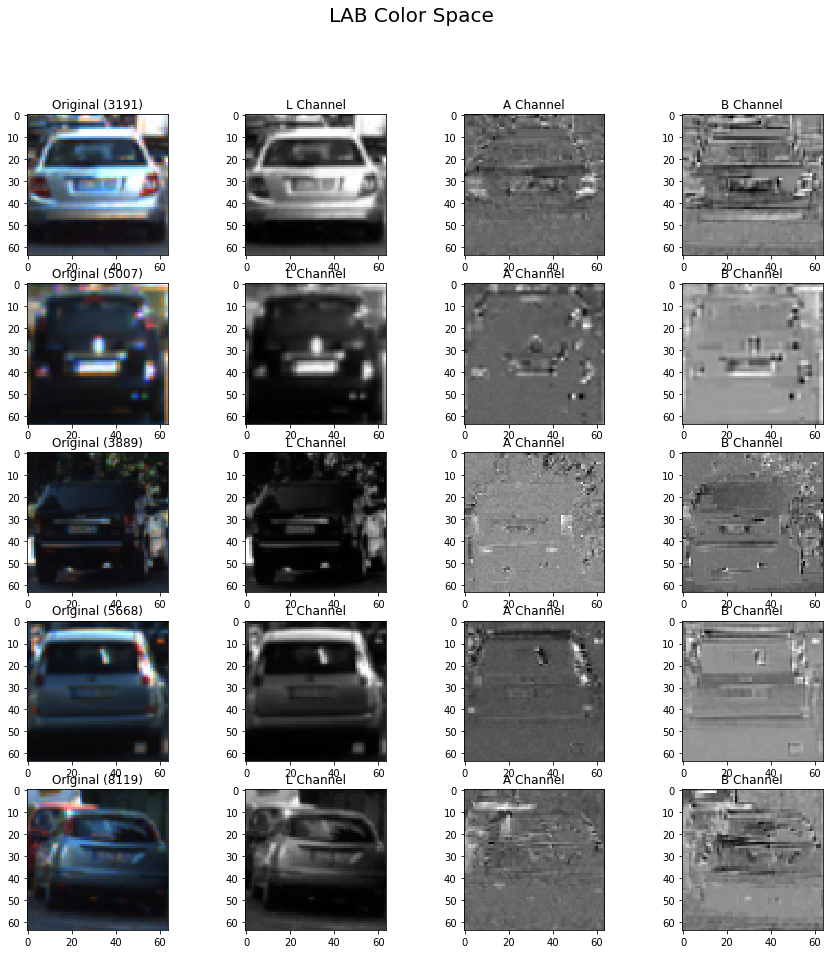

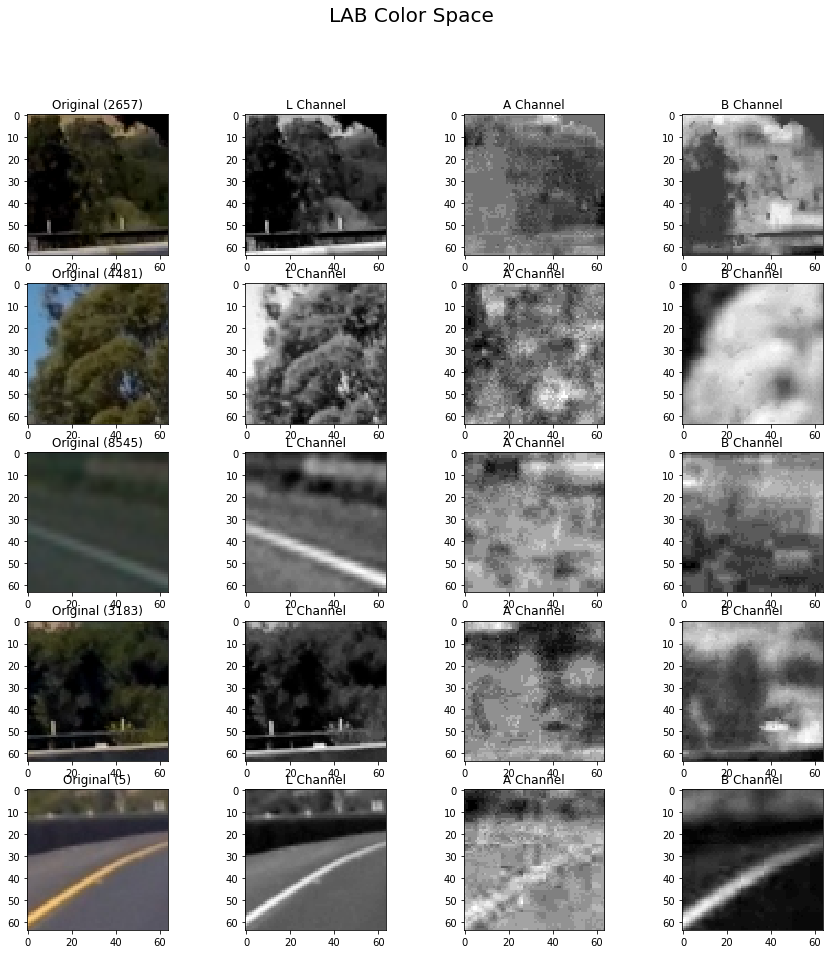

In [2]:
from lesson_functions import *

color_space = 'LAB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

def display_random(filenames, n_samples):
    f, ax = plt.subplots(n_samples, 4, figsize=(15,15))
    f.suptitle(color_space + " Color Space", fontsize=20)

    indices = np.random.choice(len(filenames), n_samples, replace=False)
    
    for i in range(n_samples):
        index = indices[i]
        img = load_image(filenames[index], color_space)
        rgb = load_image(filenames[index], 'RGB')

        ax[i,0].imshow(rgb)
        ax[i,0].set_title('Original ({})'.format(index))

        for j in range(3):
            ax[i,1 + j].imshow(img[:,:,j], cmap='gray')
            ax[i,1 + j].set_title(color_space[j] + ' Channel')

display_random(cars, 5)
display_random(notcars, 5)
plt.show()

## Hog Test Sample

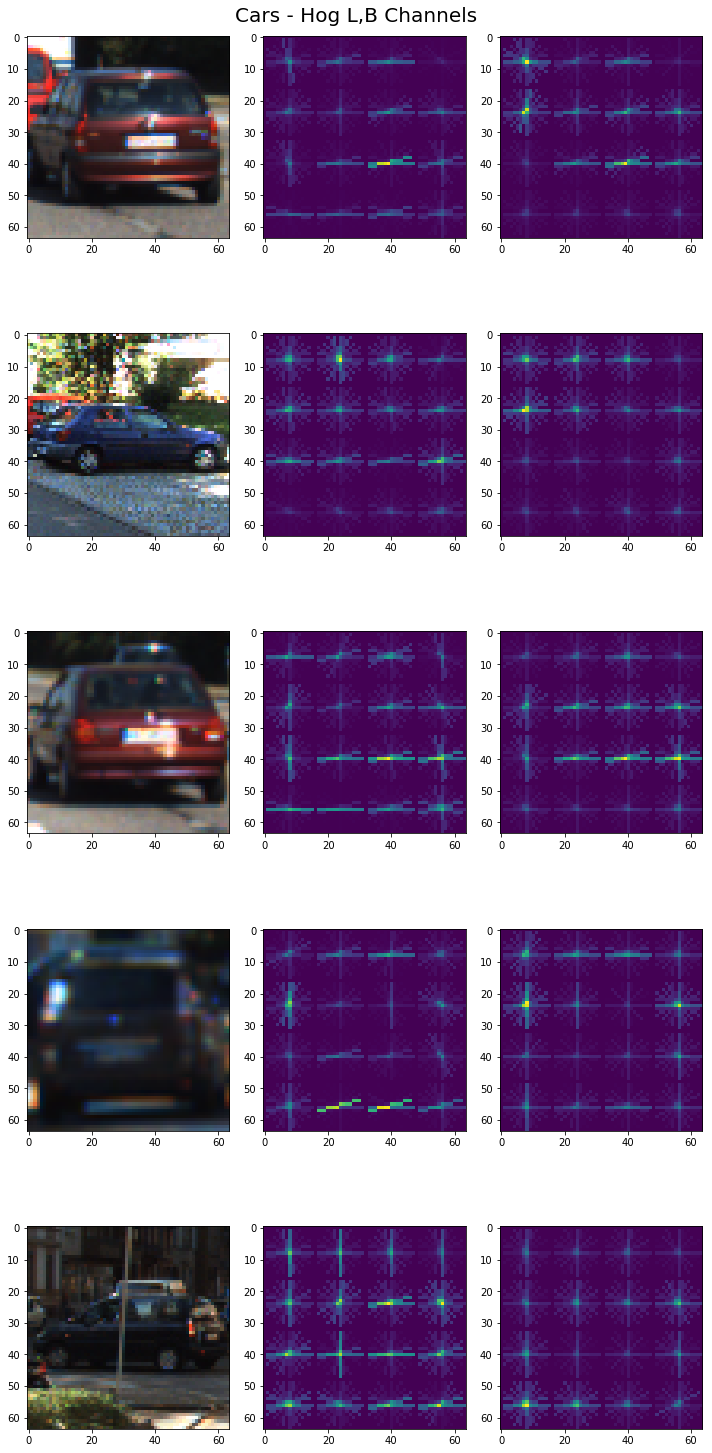

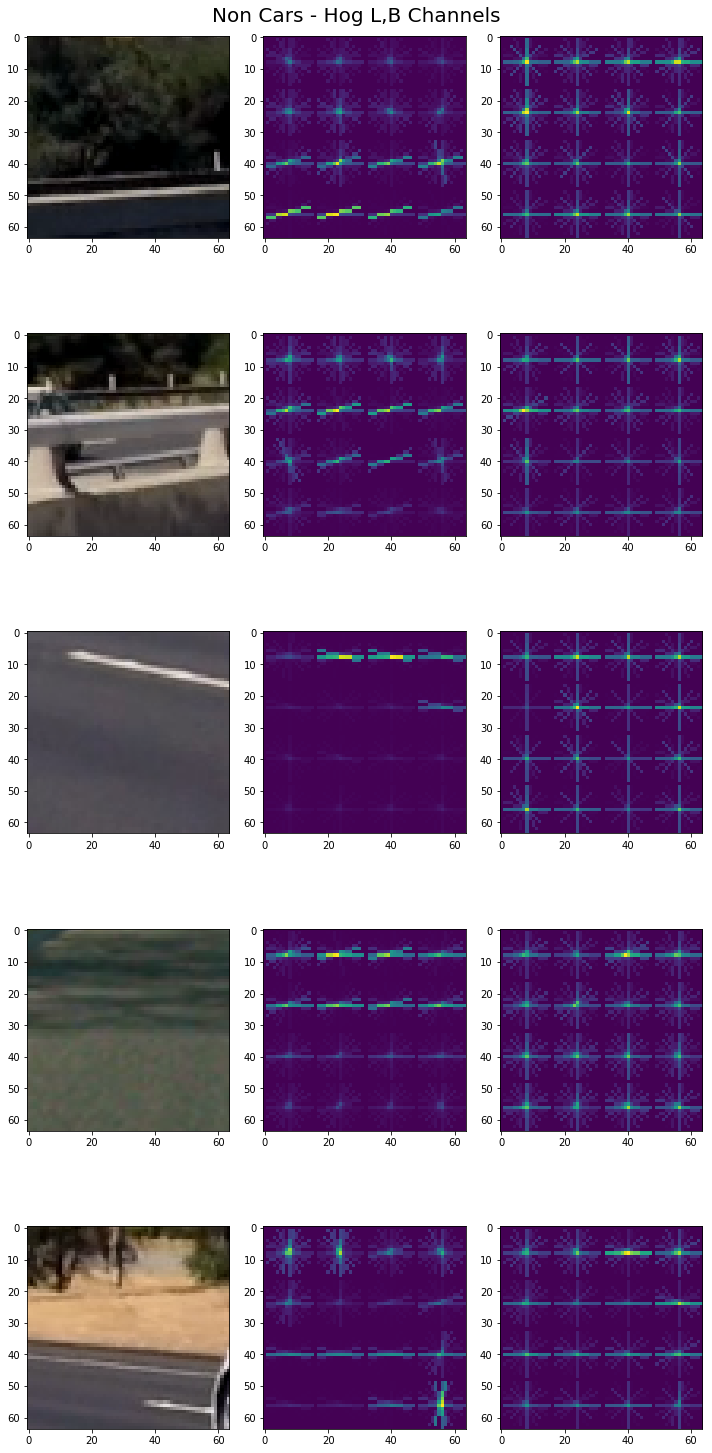

In [3]:
orient = 12
pix_per_cell = 16
cell_per_block = 4

n_samples = 5

def show_hog(title, filenames):
    indices = np.random.choice(len(filenames), n_samples)
    
    f, ax = plt.subplots(n_samples, 3, figsize=(10,21))
    f.suptitle(title, fontsize=20)

    for i in range(n_samples):
        index = indices[i]

        lab = load_image(filenames[index], color_space)
        L = lab[:,:,0]
        B = lab[:,:,1]
        
        _, hog_img_l = get_hog_features(L, orient=orient, pix_per_cell=pix_per_cell, 
                                        cell_per_block=cell_per_block, vis=True)
                                        
        _, hog_img_b = get_hog_features(B, orient=orient, pix_per_cell=pix_per_cell, 
                                        cell_per_block=cell_per_block, vis=True)
        
        img = load_image(filenames[index], 'RGB')
        ax[i,0].imshow(img)
        ax[i,1].imshow(hog_img_l)
        ax[i,2].imshow(hog_img_b)
    
    f.tight_layout()

show_hog('Cars - Hog L,B Channels', cars)
show_hog('Non Cars - Hog L,B Channels', notcars)

plt.show()

## Spatial Features
Shows effects of spatial size, which is just a resize of image and then raveling it

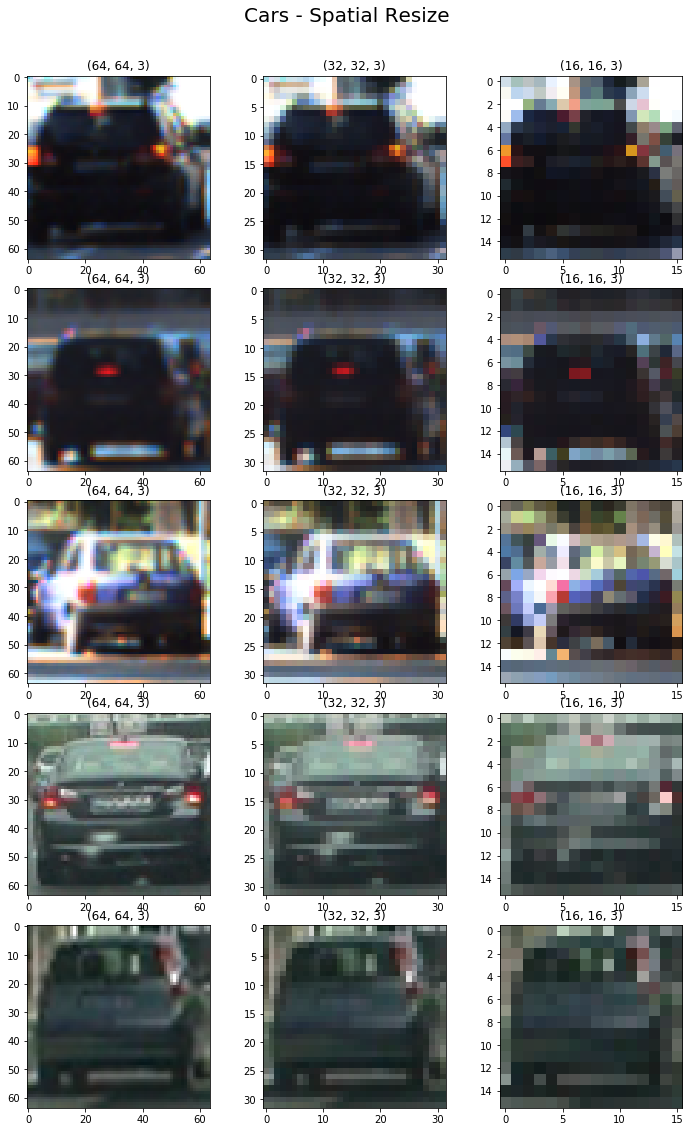

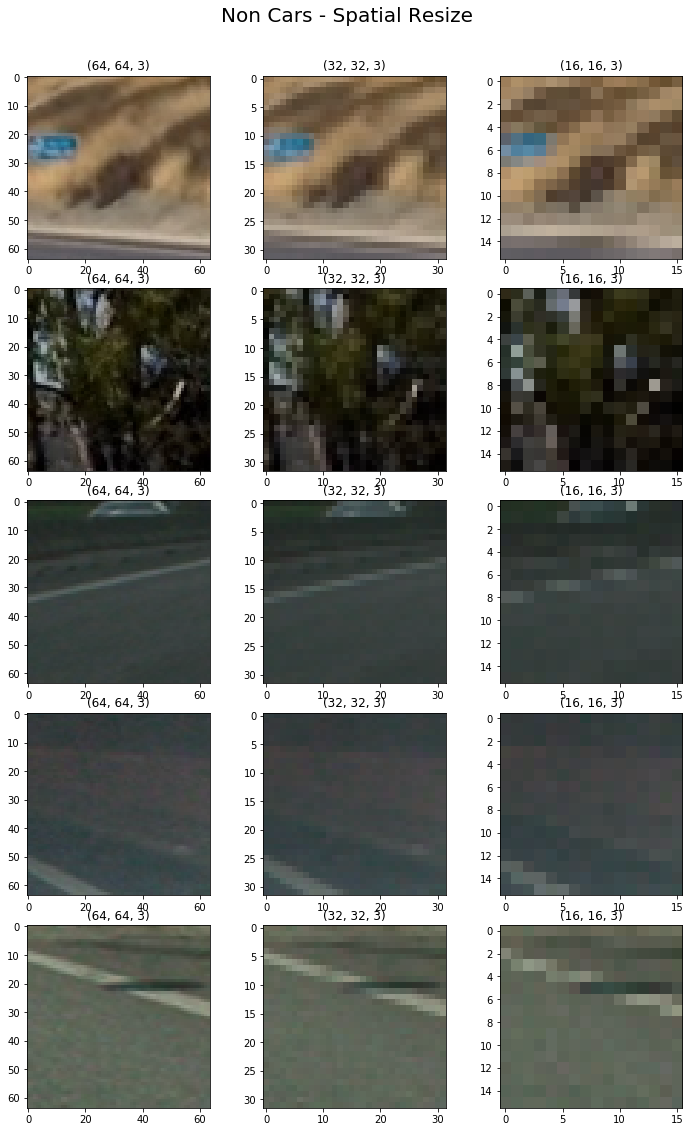

In [4]:
n_samples = 5

def show_resize(title, filenames):
    indices = np.random.choice(len(filenames), n_samples)
    
    f, ax = plt.subplots(n_samples, 3, figsize=(10,16))
    f.tight_layout()
    f.suptitle(title, fontsize=20)
    f.subplots_adjust(top=0.92)
    
    for i in range(n_samples):
        index = indices[i]

        img = []
        img.append(load_image(filenames[index], 'RGB'))
        img.append(cv2.resize(img[0], (32,32)))
        img.append(cv2.resize(img[0], (16,16)))
        
        for j in range(len(img)):
            ax[i,j].imshow(img[j])
            ax[i,j].set_title(img[j].shape)

show_resize('Cars - Spatial Resize', cars)
show_resize('Non Cars - Spatial Resize', notcars)
plt.show()

## Color Histogram

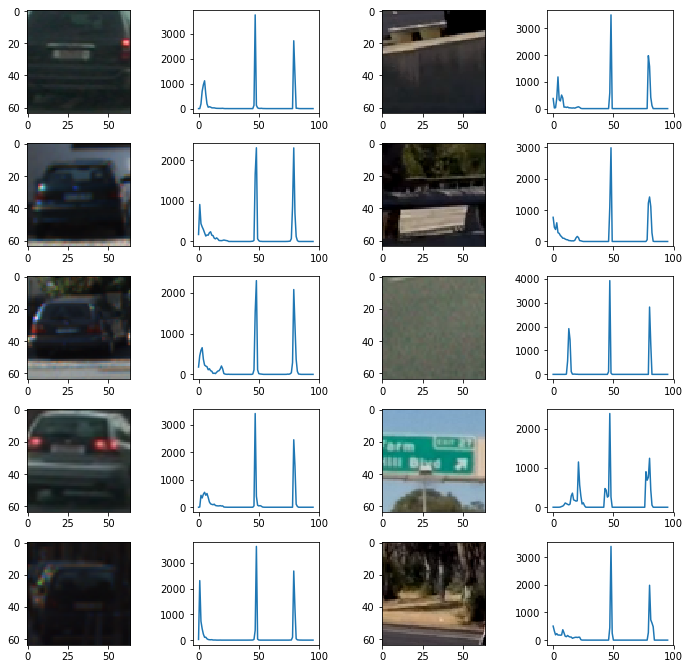

In [5]:
n_samples = 5

indices = np.random.choice(len(cars), n_samples)

f, ax = plt.subplots(n_samples, 4, figsize=(10,10))
f.tight_layout()
f.subplots_adjust(top=0.92)

for i in range(n_samples):
    index = indices[i]
    
    color_space = 'LAB'
    
    car_img = load_image(cars[index], color_space)
    notcar_img = load_image(notcars[index], color_space)
    car_features = color_hist(car_img)
    notcar_features = color_hist(notcar_img)

    #  for displaying show RGB on screen
    car_img = load_image(cars[index], "RGB")
    notcar_img = load_image(notcars[index], "RGB")

    ax[i,0].imshow(car_img)
    ax[i,1].plot(car_features)
    ax[i,2].imshow(notcar_img)
    ax[i,3].plot(notcar_features)

plt.show()

## Gradient of Image

In [6]:
# def show_grad(filenames, index):
#     #gray = load_image(filenames[index], 'GRAY')
#     img = load_image(filenames[index], 'LAB')
#     gray = img[:,:,0]
#     img = cv2.GaussianBlur(gray, (3,3), 0)
    
#     laplacian = cv2.Laplacian(img, cv2.CV_64F)
#     sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
#     sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    
#     f, ax = plt.subplots(1, 4, figsize=(10,5))
#     ax[0].imshow(img, cmap='gray')
#     ax[1].imshow(laplacian, cmap='gray')
#     ax[2].imshow(sobelx, cmap='gray')
#     ax[3].imshow(sobely, cmap='gray')

# def get_laplacian_hog(channel, visualise = False, ravel = False):
#     laplacian = get_laplacian(channel)
#     hog_laplacian = hog(laplacian, orientations=9, 
#                             pixels_per_cell=(8, 8),
#                             cells_per_block=(2, 2), 
#                             transform_sqrt=False, 
#                             visualise=visualise, 
#                             feature_vector=False,
#                             block_norm='L2-Hys')
    
#     if ravel == True:
#         return np.ravel(hog_laplacian)
    
#     return hog_laplacian
    
# def show_laplac(title, filenames):
#     indices = np.random.choice(len(filenames), n_samples)
    
#     f, ax = plt.subplots(n_samples, 3, figsize=(20,16))
#     f.tight_layout()
#     f.suptitle(title, fontsize=20)
#     f.subplots_adjust(top=0.92)

#     orient = 9  # HOG orientations
#     pix_per_cell = 8 # HOG pixels per cell
#     cell_per_block = 2 # HOG cells per block

#     for i in range(n_samples):
#         index = indices[i]
        
#         img = load_image(filenames[index], 'LAB')
#         L = img[:,:,0]

#         _, hog_img_l = get_laplacian_hog(L, visualise=True)

#         laplacian = get_laplacian(L)

#         ax[i,0].imshow(img, cmap='gray')
#         ax[i,0].set_title('L Channel')
#         ax[i,1].imshow(laplacian, cmap='gray')
#         ax[i,1].set_title('Laplacan ' + str(laplacian.shape))
#         ax[i,2].imshow(hog_img_l, cmap='gray')
#         ax[i,2].set_title('Hog ' + str(hog_img_l.shape))

        
# show_laplac('Cars Laplacian', cars)
# show_laplac('Non Cars Laplacian', notcars)

# plt.show()

## Features Chosen

Color Space: LAB

Hog of L and B channels

Hog of LapLacian of L Channel

[Spatial Features 32 x 32][Hog Laplacian of 16x16][Hog of L Channel 32 x 32][Hog of B Channel 32 x 32]

In [7]:
from skimage.feature import hog
import pickle
import os
from lesson_functions import *

%reload_ext autoreload
%autoreload 2

orient = 12
pix_per_cell = 16
cell_per_block = 4
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
laplacian_feat = True
color_space='LAB'

# pipeline = FeaturePipeLine()
# pipeline.add(SpatialFeature())
# pipeline.add(HogFeature())
# pipeline.add(HistogramFeature())

# pipeline.process(cars)

print('Extracting car features')
car_features = extract_features(cars, color_space=color_space, orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block, hog_channel=0,
                               spatial_feat = spatial_feat,
                               hist_feat = hist_feat,
                               hog_feat = hog_feat)

print('Extracting notcar features')
notcar_features = extract_features(notcars, color_space=color_space, orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block, hog_channel=0,
                               spatial_feat = spatial_feat,
                               hist_feat = hist_feat,
                               hog_feat = hog_feat)

print('Scaling combined features')
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# X_scaler = StandardScaler().fit(X)
# scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print('Splitting into training and testing')
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

X_train_scaler = StandardScaler().fit(X_train)
X_train = X_train_scaler.transform(X_train)
X_test = X_train_scaler.transform(X_test)


print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)

Extracting car features
Extracting notcar features
Scaling combined features
Splitting into training and testing
X_train size: (14208, 3936)
y_train size: (14208,)
X_test size: (3552, 3936)
y_test size: (3552,)


## SVM Training

In [8]:
svc = LinearSVC()

t = time.time()
print('Starting training...')

svc.fit(X_train, y_train)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

t = time.time()
print('Time for accuracy testing', t - t2)


Starting training...
7.42 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9904
Time for accuracy testing 0.1060037612915039


In [17]:
with open('svm.p', 'wb') as f:
    data = {'svm':svc, 
            'scaler': X_train_scaler,
            'orient' : orient,
            'pix_per_cell' : pix_per_cell,
            'cell_per_block' : cell_per_block,
            'spatial_feat' : spatial_feat,
            'hist_feat' : hist_feat,
            'hog_feat' : hog_feat,
            'laplacian_feat' : laplacian_feat,
            'color_space': color_space
           }
    pickle.dump(data, f)
    
print('Classifier saved to svm.p')

Classifier saved to svm.p


In [21]:
svc = None
# loading it and test if correctly classifies
with open('svm.p', 'rb') as f:
    data = pickle.load(f)
    svc = data['svm']
    X_train_scaler = data['scaler']
    
print('Classifier loaded, testing on training')
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# check on all non-cars from video

filenames = glob.glob('./problem/*.jpeg')
video_test = extract_features(filenames, color_space=color_space, 
                               orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block, hog_channel=0,
                               spatial_feat = spatial_feat,
                               hist_feat = hist_feat,
                               hog_feat = hog_feat)

video_test_feat = np.array(video_test)
video_test_scaled = X_train_scaler.transform(video_test_feat)
y = np.zeros(video_test_feat.shape[0])

print('Test Accuracy on non-car video frames = ', round(svc.score(video_test_scaled, y), 4))


Classifier loaded, testing on training
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9904
Test Accuracy on non-car video frames =  0.9846


In [11]:
from lesson_functions import *

%reload_ext autoreload
%autoreload 2

img = load_image('./test_images/test1.jpg', "LAB")

box = [(1040,390),(1280,510)]
print(box[1][0] - box[1][0])
#cv2.rectangle(img, box[0], box[1], (255,0,0), 3)
#plt.imshow(img)
#plt.show()

box_pixels = img[box[0][1]:box[1][1], box[0][0]:box[1][0]]

#plt.imshow(box_pixels)
#plt.show()

small_img = cv2.resize(box_pixels, (64,64))
features = extract_feature_image(small_img, orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block, hog_channel=0,
                               spatial_feat = spatial_feat,
                               hist_feat = hist_feat,
                               hog_feat = hog_feat)

features = np.ravel(features)
scaled_img = X_train_scaler.transform([features])

print(svc.predict(scaled_img))



0
[ 1.]


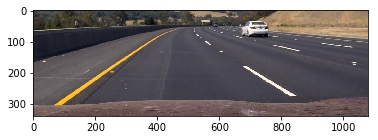

In [12]:
import matplotlib.pyplot as plt
from lesson_functions import *

%reload_ext autoreload
%autoreload 2

img = load_image('./test_images/test3.jpg', "RGB")

img = img[380:,200:]
plt.imshow(img)
plt.show()
